In [77]:
import cv2
import numpy as np

def preprocess(img, target_h=20, max_w=128):
    """
    Resize grayscale img so its height == target_h, then
    scale width, and pad or truncate to max_w. Returns
    a float32 array shape (target_h, max_w, 1) in [0,1].
    """
    h, w = img.shape[:2]

    # 1) Scale so height == target_h
    scale = target_h / float(h)
    new_w = int(w * scale)
    img = cv2.resize(img, (new_w, target_h))

    # 2) Pad or truncate width to max_w
    if new_w < max_w:
        # pad right side with white (255)
        pad = np.ones((target_h, max_w - new_w), dtype=img.dtype) * 255
        img = np.concatenate([img, pad], axis=1)
    else:
        # truncate any extras on the right
        img = img[:, :max_w]

    # 3) Normalize to [0,1] and add channel dim
    img = img.astype('float32') / 255.0
    return img[..., np.newaxis]  # shape (32, max_w, 1)


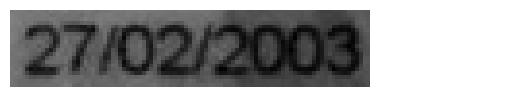

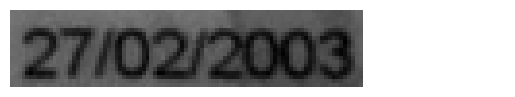

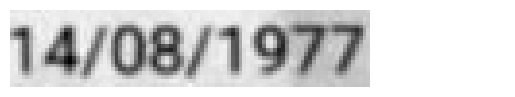

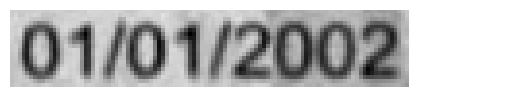

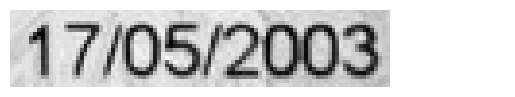

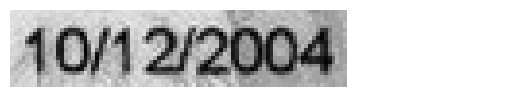

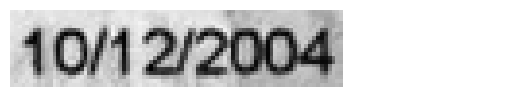

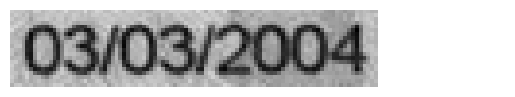

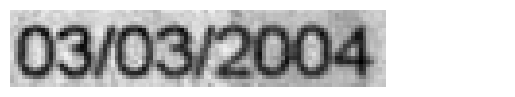

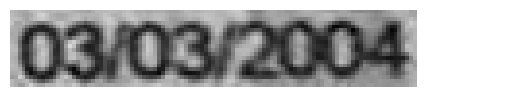

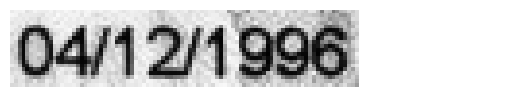

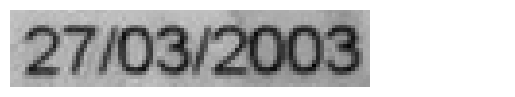

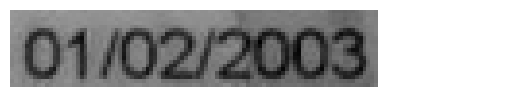

In [113]:
import glob
for path in glob.glob('cropped_my_dob_test/*.jpg'):
    img = cv2.imread(path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    img = preprocess(img, target_h=20, max_w=128)
    import matplotlib.pyplot as plt

    plt.imshow(img, cmap='gray')
    plt.axis('off')
    plt.show()


In [86]:
import os, glob, cv2, numpy as np
from tensorflow.keras.preprocessing.sequence import pad_sequences
import pandas as pd, string

# Ground truth map
gt = pd.read_csv('gt_2s.csv', dtype=str)
gt['filename'] = gt['filename'].str.replace(r'\.jpe?g$|\.png$', '', regex=True)
label_map = dict(zip(gt['filename'], gt['dob']))

# Vocabulary & encoder
char_list   = string.ascii_letters + string.digits
blank_index = len(char_list)
char_to_idx = {c:i for i,c in enumerate(char_list)}

def encode_to_labels(txt):
    return [char_to_idx[c] for c in txt if c in char_to_idx]

def load_split(folder_path, target_h=20, max_w=128):
    imgs, seqs, inp_lens, lbl_lens = [], [], [], []
    for img_path in glob.glob(os.path.join(folder_path, '*.jpg')):
        base = os.path.splitext(os.path.basename(img_path))[0]
        if base not in label_map:
            continue
        txt = label_map[base]
        raw = cv2.imread(img_path)
        raw= cv2.cvtColor(raw, cv2.COLOR_BGR2GRAY)
        # 1) Read grayscale
        h, w = raw.shape
        # skip if extremely small/large
        if h < 4 or w < 4:
            continue

        # 2) Preprocess to (32,128,1)
        img = preprocess(raw, target_h=target_h, max_w=max_w)

        # 3) Encode & record lengths
        seq= encode_to_labels(txt)
        imgs.append(img)
        seqs.append(seq)
        # Calculate input length based on model's output shape (31 timesteps)
        inp_lens.append(31)
        lbl_lens.append(len(seq))

    # 4) Determine max label length here if you want per-split, or do later globally
    return imgs, seqs, inp_lens, lbl_lens

# Load your data
train_imgs, train_seqs, train_in_l, train_lb_l = load_split('cropped_dob_train')
valid_imgs, valid_seqs, valid_in_l, valid_lb_l = load_split('cropped_dob_valid')

# 5) Global padding
max_label_len = max(
    max(len(s) for s in train_seqs),
    max(len(s) for s in valid_seqs)
)

train_labels = pad_sequences(train_seqs, maxlen=max_label_len,
                             padding='post', value=len(char_list))
valid_labels = pad_sequences(valid_seqs, maxlen=max_label_len,
                             padding='post', value=len(char_list))

In [87]:
train_imgs_paths = [os.path.join('cropped_dob_train', f) for f in os.listdir('cropped_dob_train') if f.endswith('.jpg')]
valid_imgs_paths = [os.path.join('cropped_dob_valid', f) for f in os.listdir('cropped_dob_valid') if f.endswith('.jpg')]
# 1) Build reverse map from index → character
index_to_char = {i: c for i, c in enumerate(char_list)}

# 2) Helper to decode one padded label row
def decode_label_row(row):
    # row is a 1D array of length max_label_len
    # stop at the first blank_index or at padding (- any values >= blank_index)
    chars = []
    for idx in row:
        if idx < 0 or idx >= blank_index:
            break
        chars.append(index_to_char[idx])
    return ''.join(chars)

# 3) Print out a few examples from the training set
for i in range(5):
    # corresponding filename (without extension)
    filename = os.path.splitext(os.path.basename(train_imgs_paths[i]))[0]
    decoded = decode_label_row(train_labels[i])
    print(f"{filename}  →  {decoded}")

# 4) Likewise for validation
for i in range(5):
    filename = os.path.splitext(os.path.basename(valid_imgs_paths[i]))[0]
    print(f"{filename}  →  {decode_label_row(valid_labels[i])}")


img1275  →  17112002
img1117  →  13042003
img1329  →  15112003
img1301  →  22022003
img1300  →  26082006
img1473  →  24092005
img1467  →  11041992
img1498  →  28081985
img1466  →  19121986
img911  →  21012004


In [88]:
print(f"Train set: {len(train_imgs)} images, max label len {max_label_len}")
print(f"Valid set: {len(valid_imgs)} images, max label len {max_label_len}")
print(f"Vocabulary size: {len(char_list) + 1} (including blank)")

Train set: 185 images, max label len 8
Valid set: 59 images, max label len 8
Vocabulary size: 63 (including blank)


In [109]:
from tensorflow.keras.layers import (
    Input, Conv2D, MaxPool2D, BatchNormalization,
    SpatialDropout2D, Lambda, Bidirectional, LSTM, Dense
)
from tensorflow.keras.models import Model
import tensorflow.keras.backend as K

# 1) Input: height=20, width=128
inputs = Input(shape=(20,128,1), name="image_input")

# 2) Conv1 + pool → 20→10
x = Conv2D(32, 3, padding='same', activation='relu')(inputs)
x = BatchNormalization()(x)
x = MaxPool2D((2,2))(x)    # → (10, 64, 32)

# 3) Conv2 + pool → 10→5
x = Conv2D(64, 3, padding='same', activation='relu')(x)
x = BatchNormalization()(x)
x = MaxPool2D((2,2))(x)    # → (5,  32, 64)

# 4) Conv3 + pool3×1 → 5→1 (collapse height)
x = Conv2D(128, 3, padding='same', activation='relu')(x)
x = BatchNormalization()(x)
x = MaxPool2D((3,1))(x)    # → (1,  32, 128)

# 5) Width‐shaving conv 32→31
x = Conv2D(128, (1,2), activation='relu', padding='valid')(x)  # → (1,31,128)
x = BatchNormalization()(x)

# 6) Squeeze height → sequence length = 31
x = Lambda(lambda t: K.squeeze(t, axis=1))(x)                 # → (31,128)

# 7) Bi‐LSTM stack over 31 time‐steps
x = Bidirectional(LSTM(128, return_sequences=True, dropout=0.2))(x)
x = Bidirectional(LSTM(128, return_sequences=True, dropout=0.2))(x)

# 8) Final softmax
outputs = Dense(len(char_list) + 1, activation='softmax')(x)

# 9) Build & inspect
model = Model(inputs, outputs)
model.summary()


Model: "model_33"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 image_input (InputLayer)    [(None, 20, 128, 1)]      0         
                                                                 
 conv2d_64 (Conv2D)          (None, 20, 128, 32)       320       
                                                                 
 batch_normalization_64 (Ba  (None, 20, 128, 32)       128       
 tchNormalization)                                               
                                                                 
 max_pooling2d_49 (MaxPooli  (None, 10, 64, 32)        0         
 ng2D)                                                           
                                                                 
 conv2d_65 (Conv2D)          (None, 10, 64, 64)        18496     
                                                                 
 batch_normalization_65 (Ba  (None, 10, 64, 64)        256

In [110]:
import tensorflow as tf
from tensorflow.keras import backend as K
from tensorflow.keras.layers import Input, Lambda
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import ModelCheckpoint

# ─── your existing act_model definition ───
# inputs → convs → LSTMs → outputs (softmax over timesteps)
# assume that final softmax layer is called `outputs`

# 1) Define the four inputs

labels       = Input(shape=[max_label_len], name='the_labels',   dtype='int32')
input_length = Input(name='input_length', shape=[1], dtype='int64')
label_length = Input(name='label_length', shape=[1], dtype='int64')

print(input_length.shape, label_length.shape, labels.shape)


# 2) Use the existing model instance to define the outputs for the training model


# 3) CTC loss via Lambda
def ctc_lambda_func(args):
    y_pred, labels, input_length, label_length = args
    return K.ctc_batch_cost(labels, y_pred, input_length, label_length)

loss_out = Lambda(
    ctc_lambda_func,
    output_shape=(1,),
    name='ctc'
)([outputs, labels, input_length, label_length])

# 4) The “training model”—it outputs the loss tensor
training_model = Model(
    inputs=[inputs, labels, input_length, label_length],
    outputs=loss_out
)

training_model.compile(
    loss={'ctc': lambda y_true, y_pred: y_pred},
    optimizer=tf.keras.optimizers.legacy.Adam(learning_rate=1e-3)
)
filepath="best_model.hdf5"
checkpoint = ModelCheckpoint(filepath=filepath, monitor='val_loss', verbose=1, save_best_only=True, mode='auto')
callbacks_list = [checkpoint]


training_img = np.array(train_imgs)
train_input_length = np.array(train_in_l)
train_label_length = np.array(train_lb_l)

valid_img = np.array(valid_imgs)
valid_input_length = np.array(valid_in_l)
valid_label_length = np.array(valid_lb_l)

(None, 1) (None, 1) (None, 8)


In [111]:
training_model.fit(
    x=[training_img, train_labels, train_input_length, train_label_length],
    y=np.zeros(len(training_img)),
    batch_size=8,
    epochs=50,
    validation_data=(
        [valid_img, valid_labels, valid_input_length, valid_label_length],
        [np.zeros(len(valid_img))]
    ),
    callbacks=callbacks_list
)


Epoch 1/50
23/24 [===========================>..] - ETA: 0s - loss: 37.8747
Epoch 1: val_loss improved from inf to 20.59065, saving model to best_model.hdf5
24/24 [==============================] - 7s 120ms/step - loss: 37.7816 - val_loss: 20.5907
Epoch 2/50
23/24 [===========================>..] - ETA: 0s - loss: 17.6058
Epoch 2: val_loss improved from 20.59065 to 17.91424, saving model to best_model.hdf5
24/24 [==============================] - 2s 69ms/step - loss: 17.6029 - val_loss: 17.9142
Epoch 3/50
23/24 [===========================>..] - ETA: 0s - loss: 16.7918
Epoch 3: val_loss improved from 17.91424 to 17.64128, saving model to best_model.hdf5
24/24 [==============================] - 2s 85ms/step - loss: 16.7777 - val_loss: 17.6413
Epoch 4/50
24/24 [==============================] - ETA: 0s - loss: 16.3527
Epoch 4: val_loss improved from 17.64128 to 17.49963, saving model to best_model.hdf5
24/24 [==============================] - 2s 90ms/step - loss: 16.3527 - val_loss: 17.4

In [116]:
import glob
import os
import cv2
import numpy as np
import tensorflow as tf
from tensorflow.keras import backend as K


# 2) Load the best weights into that same model
model.load_weights('best_model.hdf5', by_name=True)

# 3) Prepare your mappings
BLANK = len(char_list)
index_to_char = {i: c for i, c in enumerate(char_list)}

# 4) Load + preprocess all validation images
valid_paths = sorted(glob.glob('cropped_dob_valid_1/*.jpg'))
imgs, bases = [], []
for p in valid_paths:
    raw = cv2.imread(p, cv2.IMREAD_GRAYSCALE)
    img = preprocess(raw, target_h=20, max_w=128)   # → (15, w, 1)
    imgs.append(img)
    bases.append(os.path.splitext(os.path.basename(p))[0])
imgs = np.stack(imgs, axis=0)    # → (N_valid, 15, w, 1)

# 5) Predict the per-timestep softmax
y_pred = model.predict(imgs)  
#    shape = (N_valid, time_steps, num_classes)

# 6) Build input lengths for CTC
input_len = np.ones((y_pred.shape[0],), dtype='int32') * y_pred.shape[1]

# 7) Greedy CTC decode
decoded, _ = K.ctc_decode(    
    y_pred,
    input_length=input_len,
    greedy=True
)
decoded = decoded[0].numpy()     # → (N_valid, ≤time_steps)

# 8) Convert integer sequences back to strings
pred_texts = []
for seq in decoded:
    # turn indices → raw digit string
    s = ''.join(index_to_char[i] for i in seq if 0 <= i < len(char_list))

    # if we have at least 8 digits, format the DOB portion
    if len(s) >= 8:
        dd, mm, yyyy = s[:2], s[2:4], s[4:8]
        rest = s[8:]   # any extra trailing digits
        s = f"{dd}/{mm}/{yyyy}{rest}"

    pred_texts.append(s)

# 1) Identify wrong and right predictions
wrong, right = [], []
for path, base, pred in zip(valid_paths, bases, pred_texts):
    true = label_map.get(base, '<missing>')
    if pred != true:
        wrong.append((os.path.basename(path), pred, true))
    else:
        right.append((os.path.basename(path), pred, true))

# 2) Print wrong predictions
print("\nWrong predictions:")
for fname, pred, true in wrong:
    print(f"{fname}  →  pred: {pred} true: {true}")

# 4) Overall accuracy
total = len(pred_texts)
num_correct = len(right)
accuracy = num_correct / total * 100
print(f"\nAccuracy: {num_correct}/{total} = {accuracy:.2f}%")


2/2 [==============================] - 0s 35ms/step

Wrong predictions:
img1389.jpg  →  pred: 05/06/1978 true: 05/06/1976
img1394.jpg  →  pred: 2081996 true: 22/08/1998
img1400.jpg  →  pred: 10/06/1999 true: 10/06/1986
img1469.jpg  →  pred: 17/05/2062 true: 17/05/2002
img1474.jpg  →  pred: 24/09/2003 true: 24/09/2005
img1486.jpg  →  pred: 01/08/2998 true: 01/08/2003
img1498.jpg  →  pred: 23/08/1985 true: 28/08/1985
img1511.jpg  →  pred: 0810191 true: 08/10/1981
img1584.jpg  →  pred: 2662663 true: 28/05/2003
img1591.jpg  →  pred: 08/10/1997 true: 05/10/1997
img1599.jpg  →  pred: 24/03/2000 true: 14/03/2000
img932.jpg  →  pred: 0412006 true: 04/12/2003

Accuracy: 48/60 = 80.00%


In [115]:
import glob
import os
import cv2
import numpy as np
import tensorflow as tf
from tensorflow.keras import backend as K


# 3) Prepare your mappings
BLANK = len(char_list)
index_to_char = {i: c for i, c in enumerate(char_list)}

# 4) Load + preprocess all validation images
valid_paths = sorted(glob.glob('cropped_my_dob_test/*.jpg'))
imgs, bases = [], []
for p in valid_paths:
    raw = cv2.imread(p, cv2.IMREAD_GRAYSCALE)
    img = preprocess(raw, target_h=20, max_w=128)   # → (15, w, 1)
    imgs.append(img)
    bases.append(os.path.splitext(os.path.basename(p))[0])
imgs = np.stack(imgs, axis=0)    # → (N_valid, 15, w, 1)

# 5) Predict the per-timestep softmax
y_pred = model.predict(imgs)  
#    shape = (N_valid, time_steps, num_classes)

# 6) Build input lengths for CTC
input_len = np.ones((y_pred.shape[0],), dtype='int32') * y_pred.shape[1]

# 7) Greedy CTC decode
decoded, _ = K.ctc_decode(    
    y_pred,
    input_length=input_len,
    greedy=True
)
decoded = decoded[0].numpy()     # → (N_valid, ≤time_steps)

# 8) Convert integer sequences back to strings
pred_texts = []
for seq in decoded:
    # turn indices → raw digit string
    s = ''.join(index_to_char[i] for i in seq if 0 <= i < len(char_list))

    # if we have at least 8 digits, format the DOB portion
    if len(s) >= 8:
        dd, mm, yyyy = s[:2], s[2:4], s[4:8]
        rest = s[8:]   # any extra trailing digits
        s = f"{dd}/{mm}/{yyyy}{rest}"

    pred_texts.append(s)


for path, base, pred in zip(valid_paths, bases, pred_texts):
    print(f"{os.path.basename(path)}  →  {pred}")



1/1 [==============================] - 0s 31ms/step
110.jpg  →  17/05/2003
28.jpg  →  14/08/1977
29.jpg  →  01/01/2002
4.jpg  →  04/12/1996
54.jpg  →  27/03/2003
60.jpg  →  27/02/2003
78.jpg  →  01/02/2003
99.jpg  →  27/02/2003
img1.jpg  →  03/03/2004
img2.jpg  →  03/03/2004
img3.jpg  →  03/03/2004
img4.jpg  →  10/12/2004
img6.jpg  →  10/12/2004


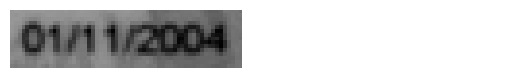

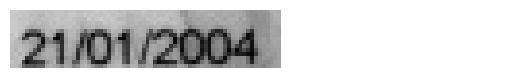

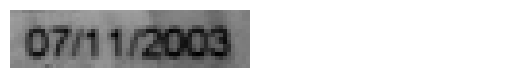

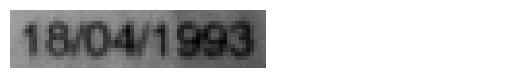

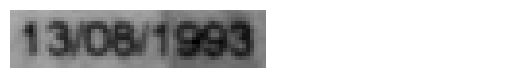

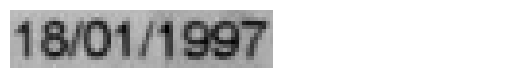

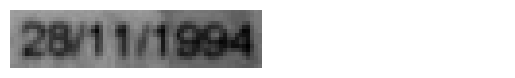

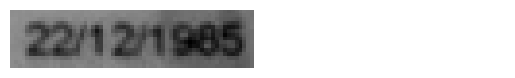

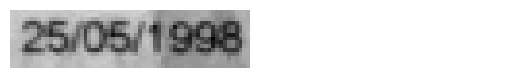

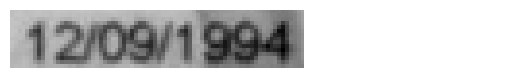

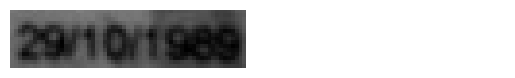

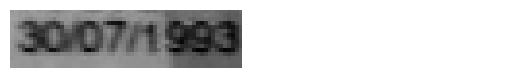

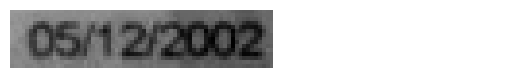

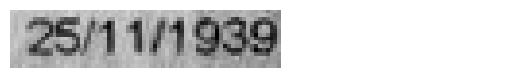

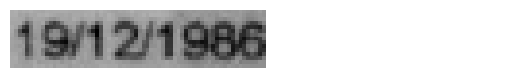

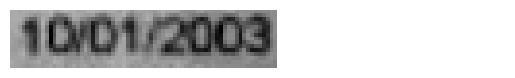

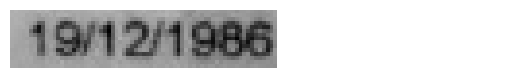

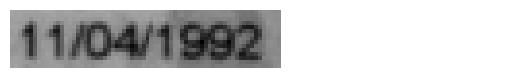

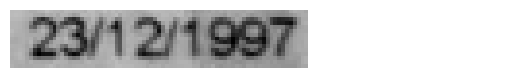

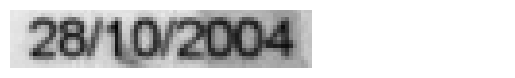

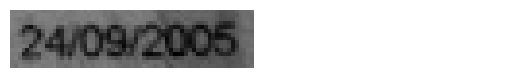

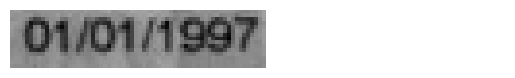

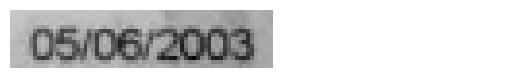

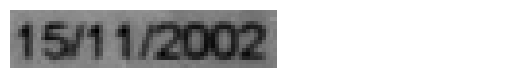

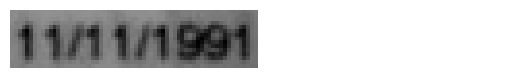

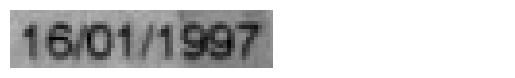

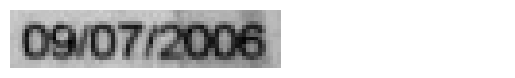

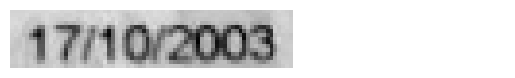

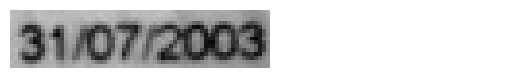

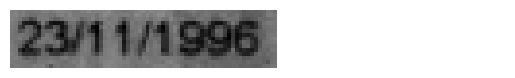

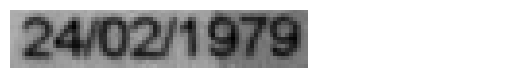

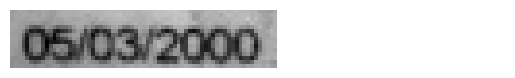

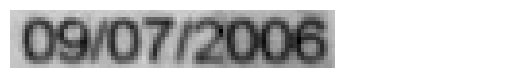

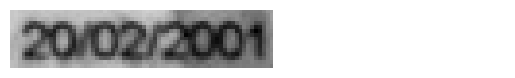

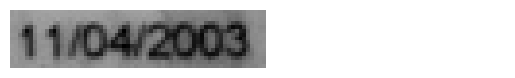

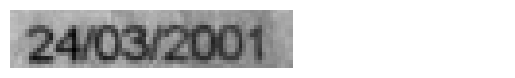

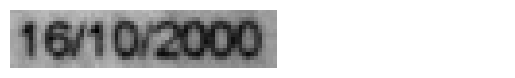

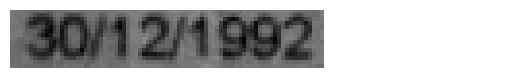

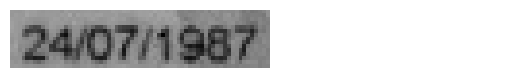

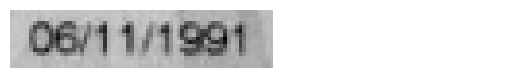

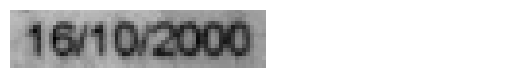

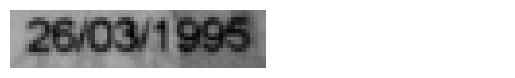

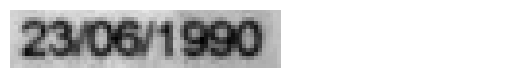

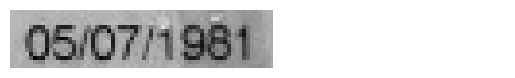

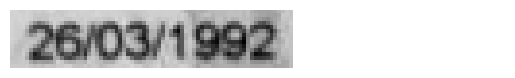

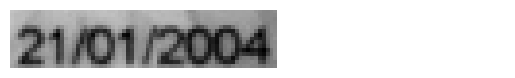

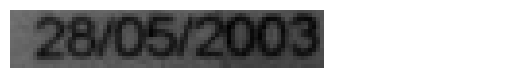

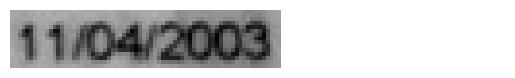

In [119]:
import os
import cv2
import matplotlib.pyplot as plt

# assume output_dir is where your crops are saved
output_dir = 'cropped_dob_valid_1'

# Show the first 5 correctly-predicted images
for fname, pred, true in right:
    img_path = os.path.join(output_dir, fname)
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    img = preprocess(img, target_h=15, max_w=128)
    
    plt.figure()
    plt.imshow(img, cmap='gray')              # display as grayscale
    plt.axis('off')
    plt.show()


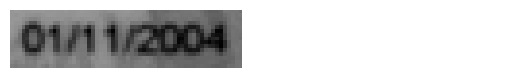

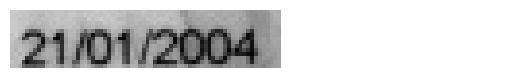

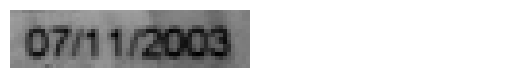

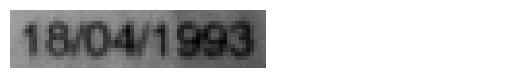

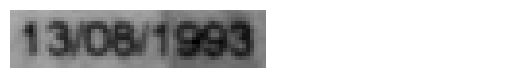

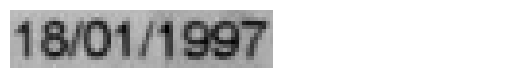

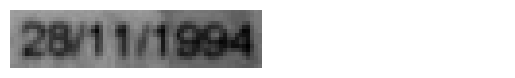

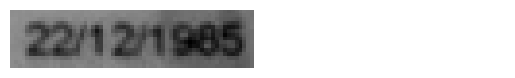

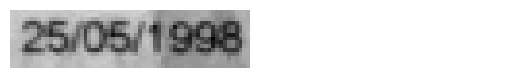

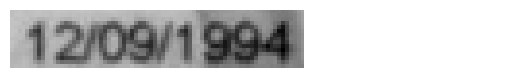

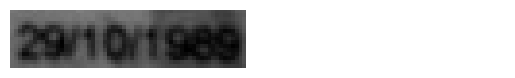

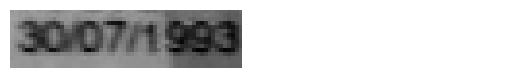

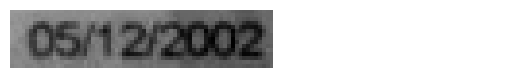

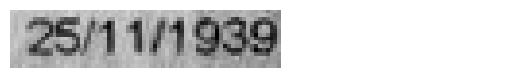

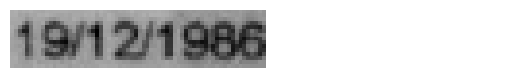

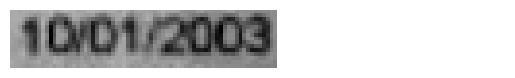

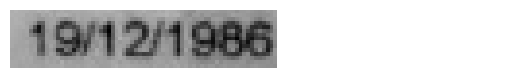

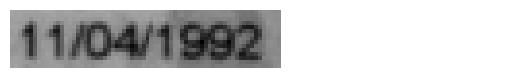

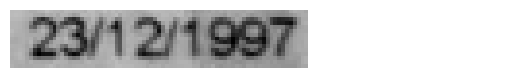

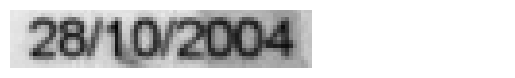

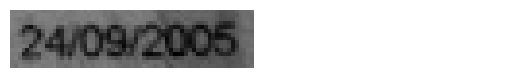

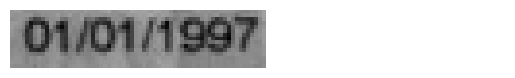

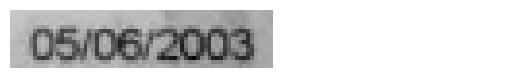

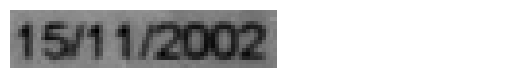

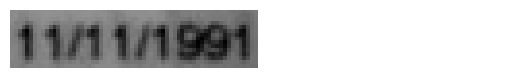

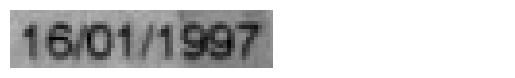

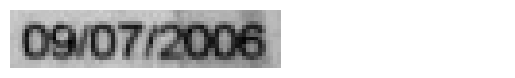

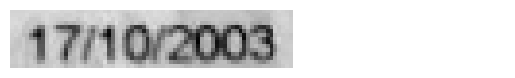

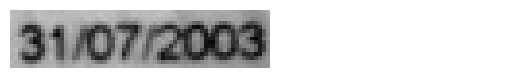

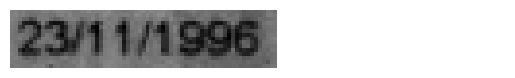

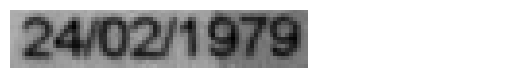

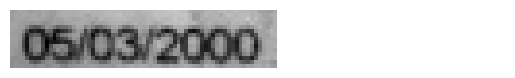

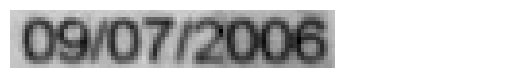

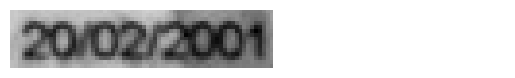

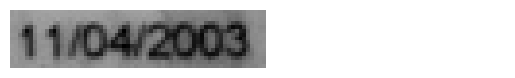

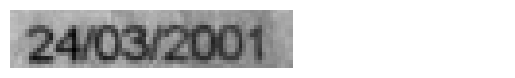

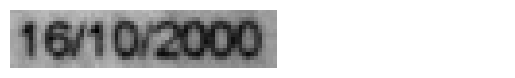

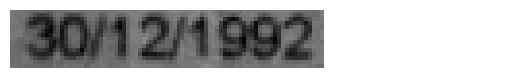

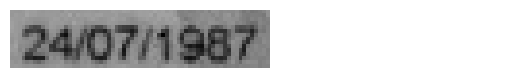

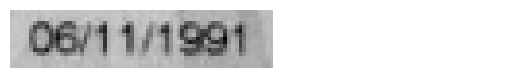

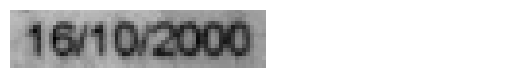

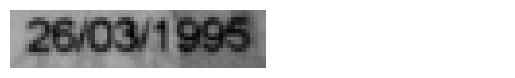

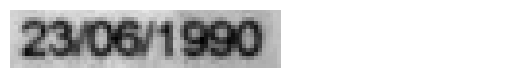

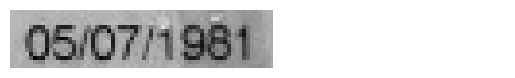

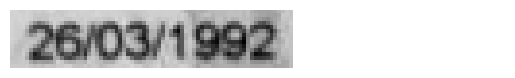

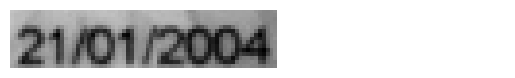

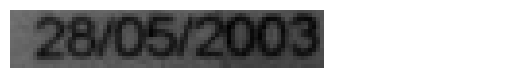

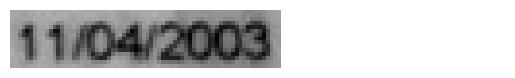

In [118]:
import os
import cv2
import matplotlib.pyplot as plt

# assume output_dir is where your crops are saved
output_dir = 'cropped_dob_valid_1'

# Show the first 5 correctly-predicted images
for fname, pred, true in right:
    img_path = os.path.join(output_dir, fname)
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    img = preprocess(img, target_h=15, max_w=128)
    
    plt.figure()
    plt.imshow(img, cmap='gray')              # display as grayscale
    plt.axis('off')
    plt.show()
